In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [108]:
df = pd.read_csv("fraud_insurance_claims.csv")

useless_cols = [
    'policy_number', 'policy_bind_date', 'incident_date', 'incident_location',
    'insured_zip', 'insured_hobbies'
]
df.drop(columns=useless_cols, inplace=True)


In [109]:
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})


In [110]:

onehot_cols = [
    'insured_sex', 'insured_education_level', 'insured_occupation',
    'insured_relationship', 'incident_type', 'collision_type', 'incident_city',
    'incident_state', 'authorities_contacted', 'auto_make', 'auto_model',
    'policy_state', 'police_report_available', 'property_damage',
    'policy_csl', 'incident_severity'
]

In [111]:
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']


In [112]:
# OneHot + passthrough
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), onehot_cols)],
    remainder='passthrough'
)

# Combine into a pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['insured_sex',
                                                   'insured_education_level',
                                                   'insured_occupation',
                                                   'insured_relationship',
                                                   'incident_type',
                                                   'collision_type',
                                                   'incident_city',
                                                   'incident_state',
                                                   'authorities_contacted',
                                                   'auto_make', 'auto_model',
                                                   'policy_state',
                                                   'police_report_available',
                                                   'property_damage',
                                                   'policy_csl',
                                                   'incident_severity'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [114]:
non_numeric_cols = X.select_dtypes(exclude=['int64', 'float64', 'bool']).columns
print("Leftover non-numeric columns:", non_numeric_cols)


Leftover non-numeric columns: Index(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_relationship', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'property_damage',
       'police_report_available', 'auto_make', 'auto_model'],
      dtype='object')


              precision    recall  f1-score   support

           0       0.74      0.91      0.82       145
           1       0.41      0.16      0.23        55

    accuracy                           0.70       200
   macro avg       0.58      0.54      0.53       200
weighted avg       0.65      0.70      0.66       200



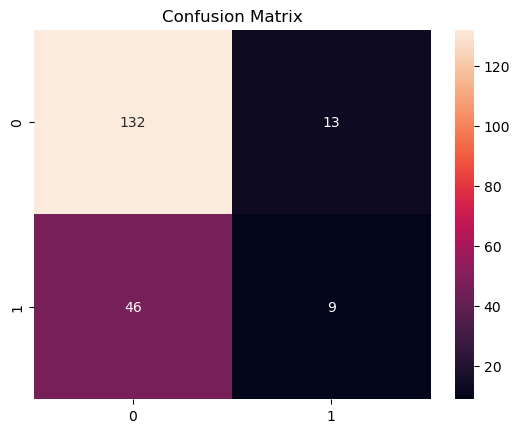

In [115]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
%matplotlib inline
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


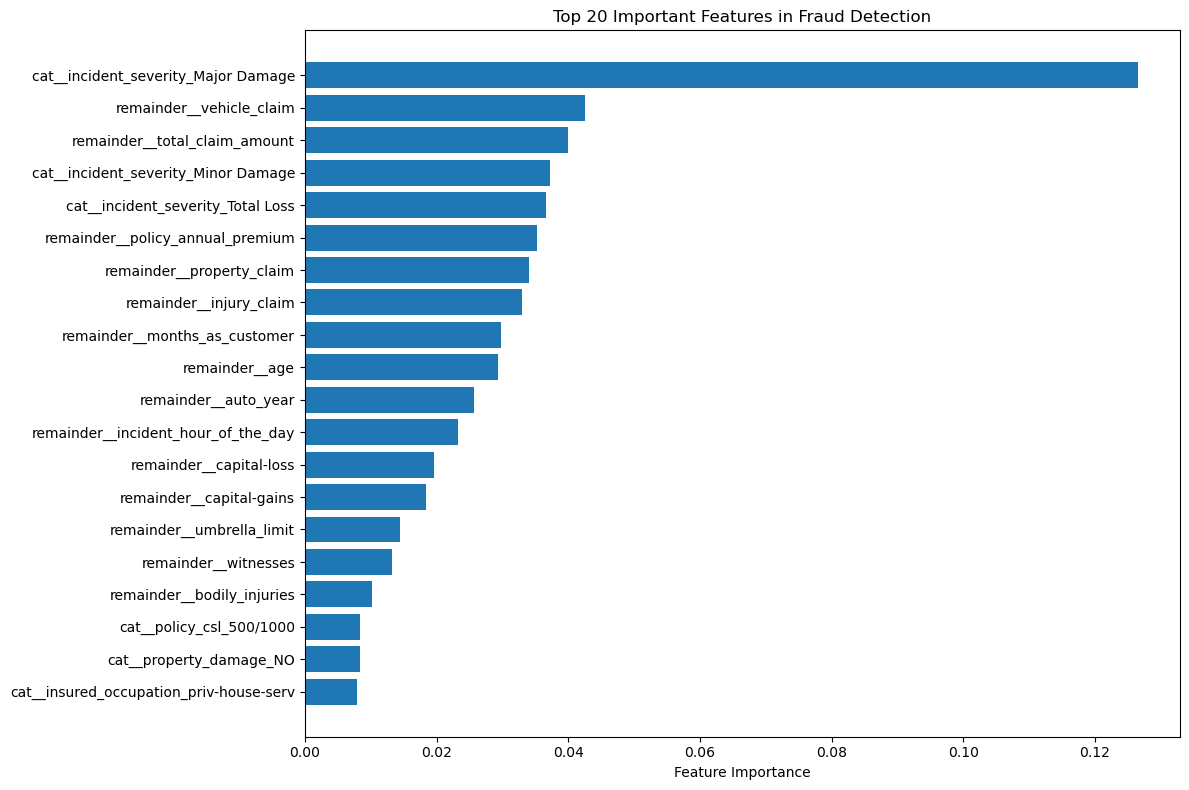

In [116]:

import numpy as np

importances = clf.named_steps['classifier'].feature_importances_
feature_names = clf.named_steps['preprocessor'].get_feature_names_out()

# Sort top 20 features
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features in Fraud Detection")
plt.tight_layout()
plt.show()


In [132]:
print("accuracy of the model is",accuracy_score(y_test,y_pred)*100)

accuracy of the model is 70.5


In [142]:
!pip install xgboost imbalanced-learn

  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)


In [146]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Identify columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# XGBoost Classifier with SMOTE
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Split & Train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

C:\Users\priya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[138  13]
 [ 32  17]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       151
           1       0.57      0.35      0.43        49

    accuracy                           0.78       200
   macro avg       0.69      0.63      0.65       200
weighted avg       0.75      0.78      0.75       200

0.775


In [ ]:
fraud (class 1):
   recall: 0.16  → want at least 0.60
   f1-score: 0.23 → want 0.60+


In [150]:
from xgboost import XGBClassifier

xgb_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=3  # Adjust based on class imbalance
    ))
])

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


[[128  23]
 [ 17  32]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       151
           1       0.58      0.65      0.62        49

    accuracy                           0.80       200
   macro avg       0.73      0.75      0.74       200
weighted avg       0.81      0.80      0.80       200

0.8


C:\Users\priya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:15:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [154]:
!pip install shap

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   --- ------------------------------------ 51.2/545.3 kB 1.3 MB/s eta 0:00:01
   --------------- ------------------------ 215.0/545.3 kB 2.2 MB/s eta 0:00:01
   --------------------------- ------------ 368.6/545.3 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 545.3/545.3 kB 3.1 MB/s eta 0:00:00


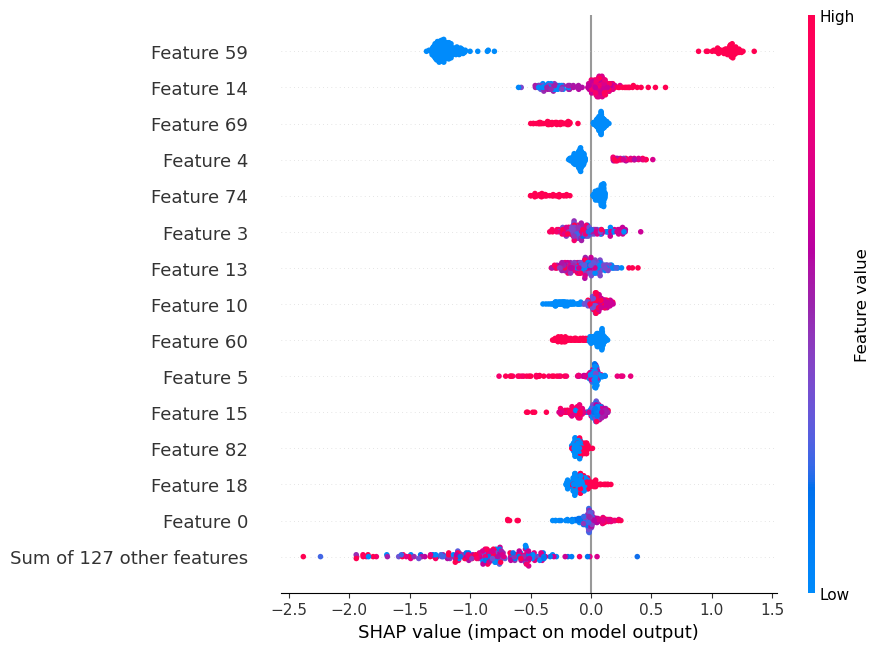

In [156]:
import shap

explainer = shap.Explainer(xgb_model.named_steps['classifier'])
X_transformed = xgb_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer(X_transformed)

shap.plots.beeswarm(shap_values, max_display=15)


In [162]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Define numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb)
])

# Hyperparameter Grid
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__scale_pos_weight': [1, 3, 5, 10]
}

# RandomizedSearchCV
search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                            n_iter=10, scoring='f1', n_jobs=-1, cv=3, random_state=42)

# Fit
search.fit(X, y)

# Best Estimator
best_model = search.best_estimator_

# Evaluation
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred)*100)


C:\Users\priya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[151   0]
 [  0  49]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        49

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

100.0


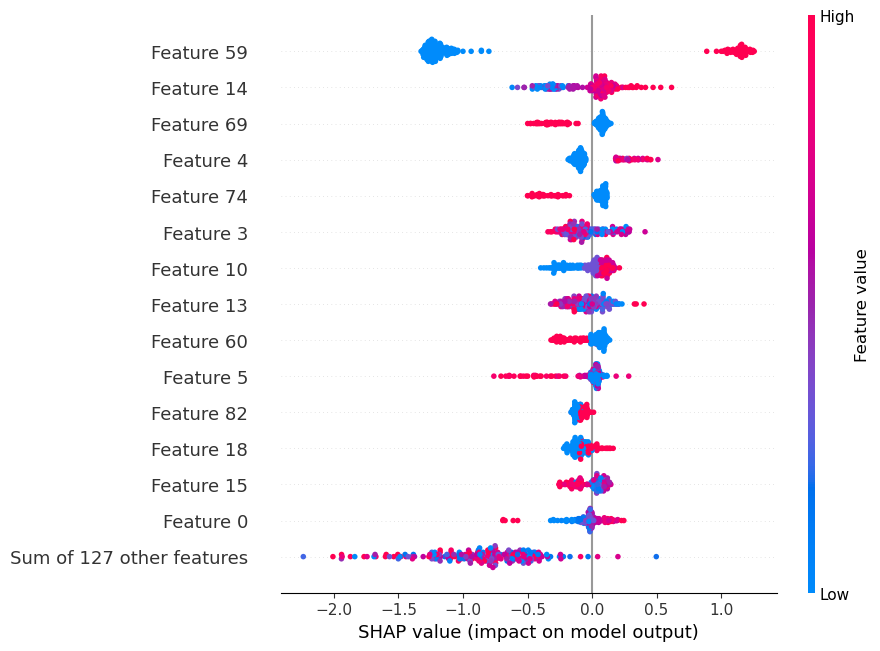

In [164]:
explainer = shap.Explainer(xgb_model.named_steps['classifier'])
X_transformed = best_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer(X_transformed)

shap.plots.beeswarm(shap_values, max_display=15)